# Dataset integration 

We will integrate the Neurons 5k dataset with a subset of 5K cells from the larger 10X dataset [1.3 million brain cells from E18 mouse](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.3.0/1M_neurons). 

In [1]:
suppressPackageStartupMessages({
library(dplyr)
library(patchwork)
library(Seurat)
library(SummarizedExperiment)
library(TENxBrainData)})

## Load data

### Pre-processing of the reference data

No need to run this during the workshop, just load the objects

In [8]:
load(file='../../data/objects/a3.refseurat.RData',verbose = TRUE)
ref.sobj[["Dataset"]]<-'nr1M'

Loading objects:
  ref.sobj


In [9]:
load(file="../../data/objects/a2.neur5k.RData",verbose = TRUE)
nr5k[['Dataset']]<-'nr5k'

Loading objects:
  nr5k
  ct


## Integrate datasets

In [ ]:
# These steps might be time consuming. Do not run this during the workshop, just load the object

options(future.globals.maxSize = 4000 * 1024^2, future.seed=NULL, warnings=FALSE)

objects <- list(nr5k,ref.sobj)
features <- SelectIntegrationFeatures(object.list = objects, nfeatures = 1000)
objects <- PrepSCTIntegration(object.list = objects, anchor.features = features, verbose = FALSE)

anchors <- FindIntegrationAnchors(object.list = objects, normalization.method = "SCT", anchor.features = features, verbose = FALSE)
nr.int <- IntegrateData(anchorset = anchors, normalization.method = "SCT", verbose = FALSE)

save(nr.int,file='../../data/objects/a3.integrated.RData')

## Visualize

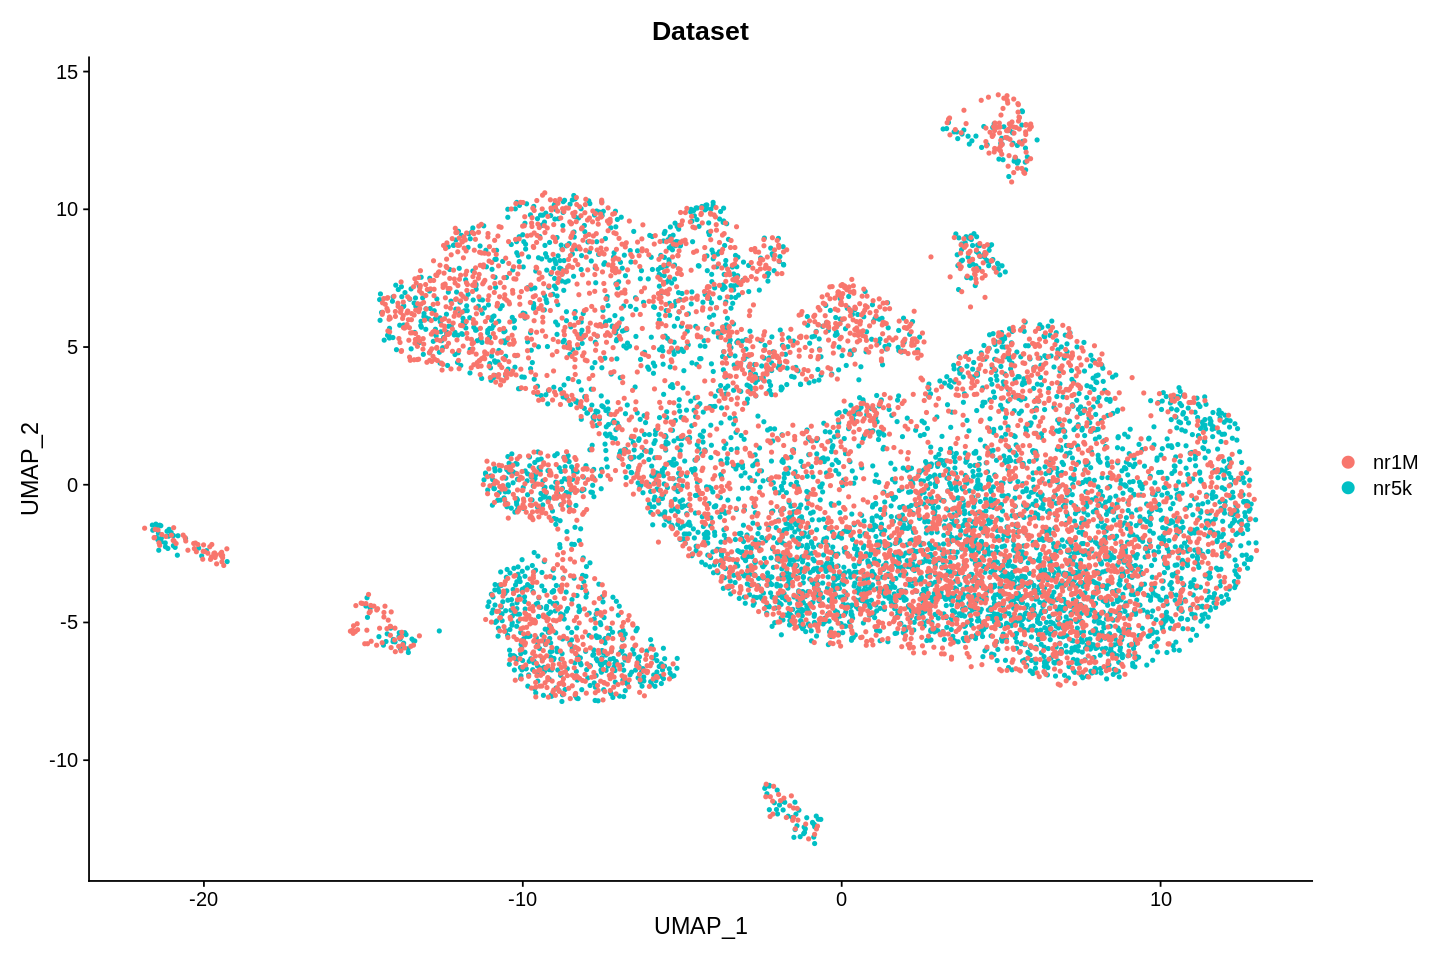

In [16]:
DimPlot(nr.int, label = FALSE,pt.size = 0.8,group='Dataset')

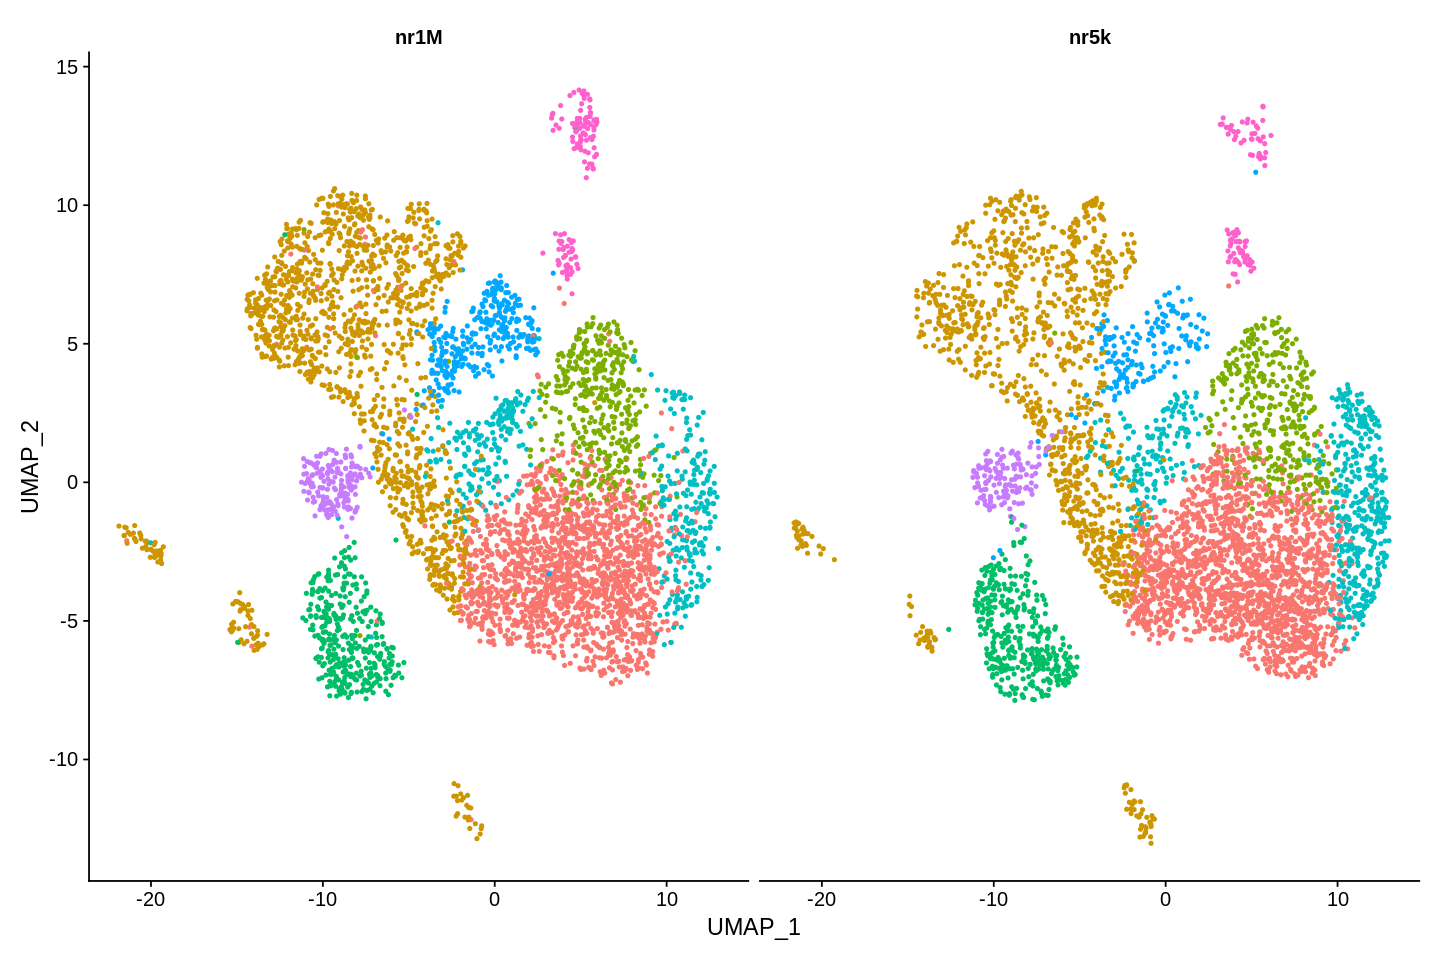

In [19]:
DimPlot(nr.int, label = FALSE,pt.size = 0.8,split.by = "Dataset")+NoLegend()

## Downstream analysis

### Hands-on activity 2

---

Perform the downstream analysis steps that we did on the previous section for the Neurons 5K dataset
1. Dimensionality reduction 
2. Clustering
3. Cell type annotation 

Could you find more cell types?

If you do not have the output from the previous sections, just load the following RData object:

In [3]:
load(file='../../data/objects/a3.integrated.RData',verbose=TRUE)

Loading objects:
  nr.int


In [4]:
nr.int <- RunPCA(nr.int, verbose = FALSE) 
nr.int <- RunUMAP(nr.int, dims = 1:30, verbose = FALSE,spread = 1,min.dist = 1)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [37]:
nr.int <- FindNeighbors(nr.int, dims = 1:20, verbose = FALSE,k.param = 20) 
nr.int <- FindClusters(nr.int, resolution = 0.8,verbose = FALSE)

In [39]:
markers <- FindAllMarkers(nr.int, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 1) %>% 
           group_by(cluster) %>% 
           top_n(n = 5, wt = avg_log2FC) 

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18



In [40]:
map<-tapply(markers$gene,markers$cluster,function(mlist,...){
    gcts<-lapply(mlist,function(m,...){ct[grep(m,ct$MarkerGenes),'Subclass']}) %>% 
          unlist() %>% 
          table() %>% 
          sort()
    return(ifelse(length(gcts)==0,'Undefined',names(gcts)[1]))
}) %>% 
unlist() 

In [41]:
nr.int <- RenameIdents(nr.int, map)

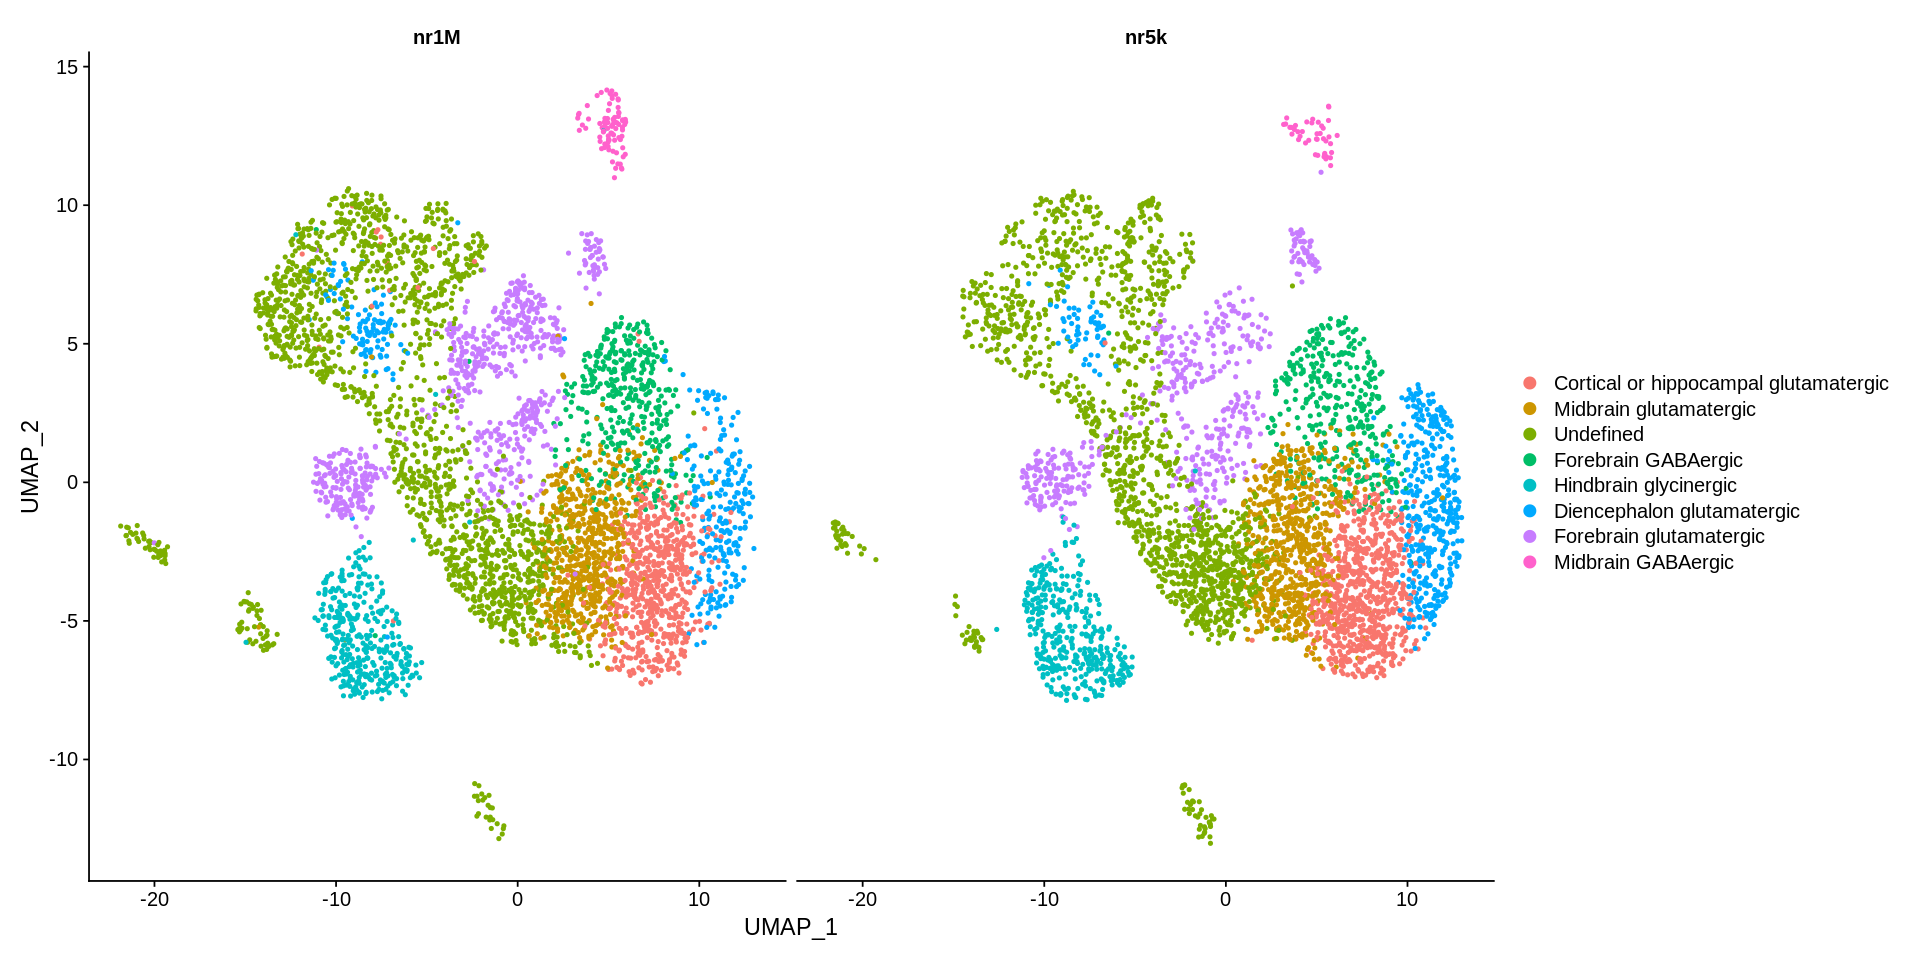

In [42]:
options(repr.plot.width=16, repr.plot.height=8)
DimPlot(nr.int, label = FALSE,pt.size = 0.8,split.by='Dataset')